# Google Trends
# Time Series Analysis and Forecasting with Seasonal ARIMA


### Murat Ova / benovamurat@gmail.com
### https://www.linkedin.com/in/ovamurat/

# Get the Data from Google Trends

In [63]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [116]:
pytrend = TrendReq(hl='tr-TR')

start_date = '2014-01-01'
end_date = '2018-12-31'
date_range = start_date + ' ' + end_date

st = ['migros'] # your search term

pytrend.build_payload(kw_list=st, timeframe = date_range)

trends = pytrend.interest_over_time()

In [65]:
df = trends.drop(columns='isPartial')
df.reset_index(inplace=True)
df.head()

,date,migros
0,2014-01-05,45
1,2014-01-12,45
2,2014-01-19,44
3,2014-01-26,45
4,2014-02-02,43


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    261 non-null    datetime64[ns]
 1   migros  261 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.2 KB


In [67]:
df.columns=['Date', 'Trend']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [68]:
df.head()

,Trend
Date,
2014-01-05,45
2014-01-12,45
2014-01-19,44
2014-01-26,45
2014-02-02,43


## Visualize

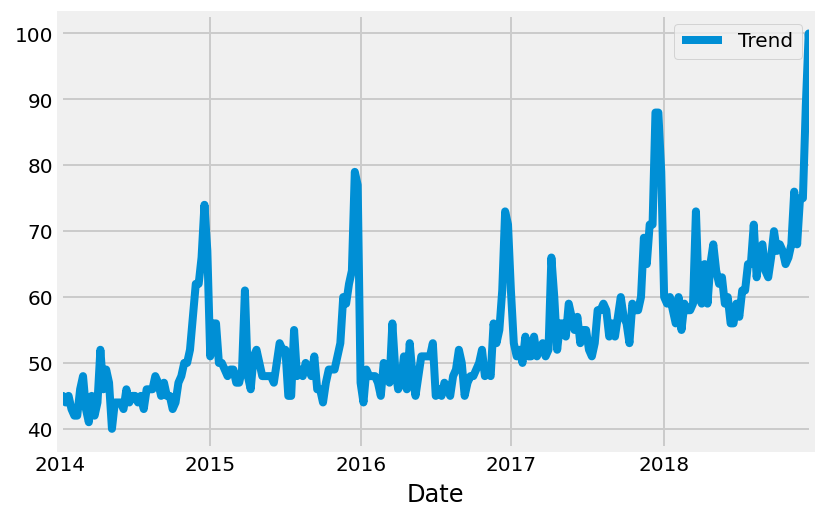

In [71]:
df.plot()

In [72]:
timeseries = df['Trend']

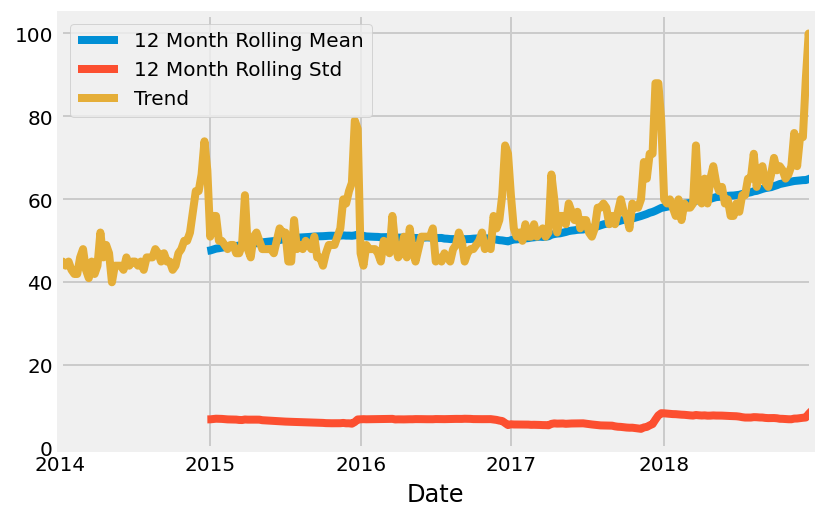

In [73]:
timeseries.rolling(52).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(52).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

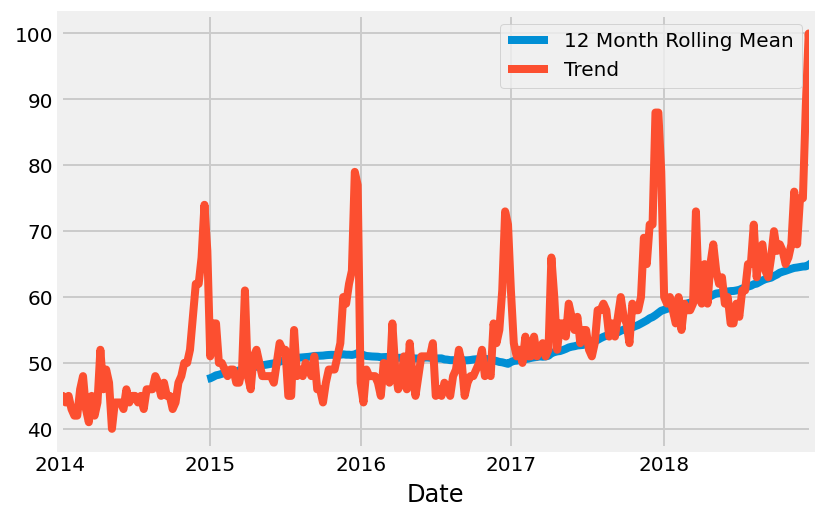

In [74]:
timeseries.rolling(52).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## ETS Decomposition

<Figure size 432x288 with 0 Axes>

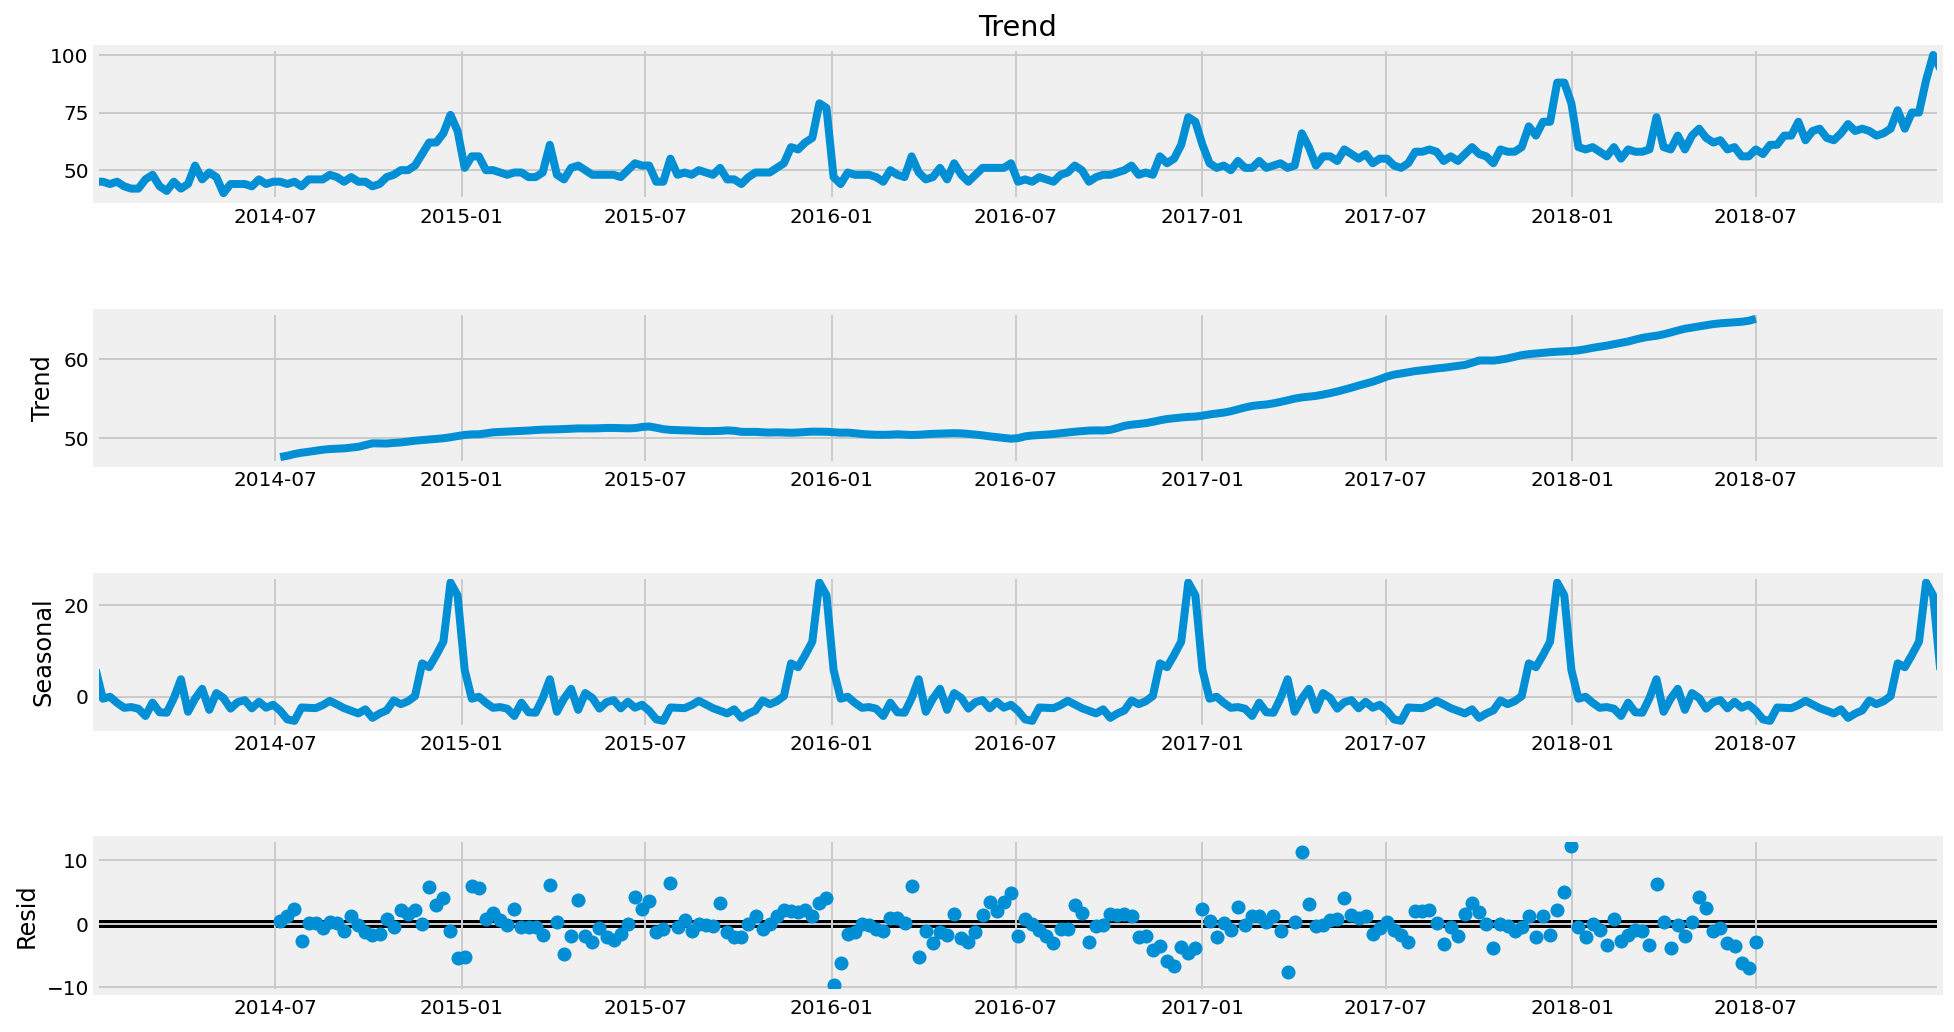

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Trend'], period=52) 
fig = plt.figure()
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Testing for Stationarity

Augmented [Dickey-Fuller], Unit Root Test

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [76]:
df.head()

,Trend
Date,
2014-01-05,45
2014-01-12,45
2014-01-19,44
2014-01-26,45
2014-02-02,43


In [77]:
from statsmodels.tsa.stattools import adfuller

In [78]:
result = adfuller(df['Trend'])

In [79]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.0350385659193706
p-value : 0.2714242947675296
#Lags Used : 2
Number of Observations Used : 258
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [80]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

## Differencing

The first difference of a time series is the series of changes from one period to the next. We can do this easily with pandas. You can continue to take the second difference, third difference, and so on until your data is stationary.

** First Difference **

In [81]:
df['Trend First Difference'] = df['Trend'] - df['Trend'].shift(1)

In [82]:
adf_check(df['Trend'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.0350385659193706
p-value : 0.2714242947675296
#Lags Used : 2
Number of Observations Used : 258
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


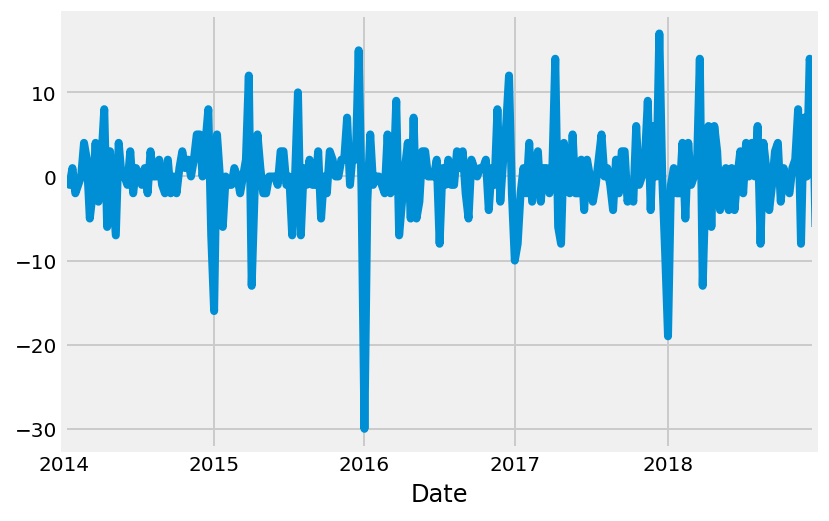

In [83]:
df['Trend First Difference'].plot()

** Second Difference **

In [84]:
# Sometimes it would be necessary to do a second difference 
# This is just for show, we didn't need to do a second difference in our case
df['Trend Second Difference'] = df['Trend First Difference'] - df['Trend First Difference'].shift(1)

In [85]:
adf_check(df['Trend Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.521005675986371
p-value : 3.7910230560692525e-11
#Lags Used : 16
Number of Observations Used : 242
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


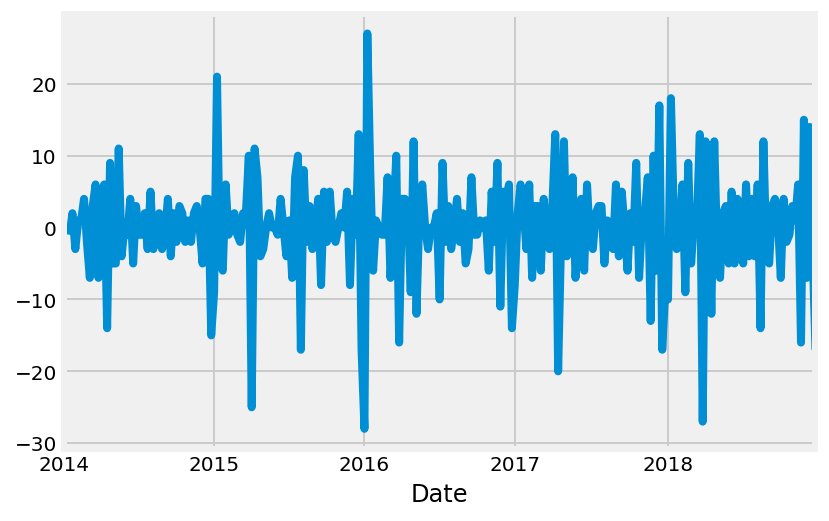

In [86]:
df['Trend Second Difference'].plot()

** Seasonal Difference **

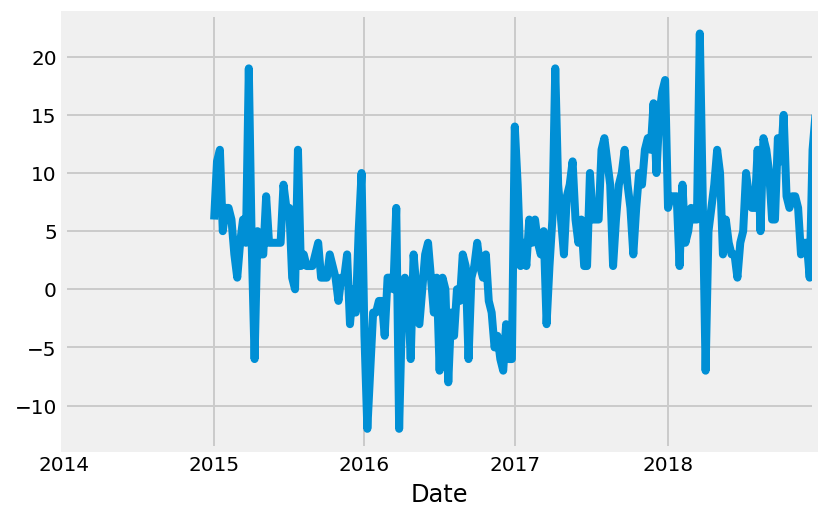

In [87]:
df['Seasonal Difference'] = df['Trend'] - df['Trend'].shift(52)
df['Seasonal Difference'].plot()

In [88]:
# Seasonal Difference by itself was not enough!
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.3794700793947854
p-value : 0.1476148586088068
#Lags Used : 5
Number of Observations Used : 203
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


** Seasonal First Difference **

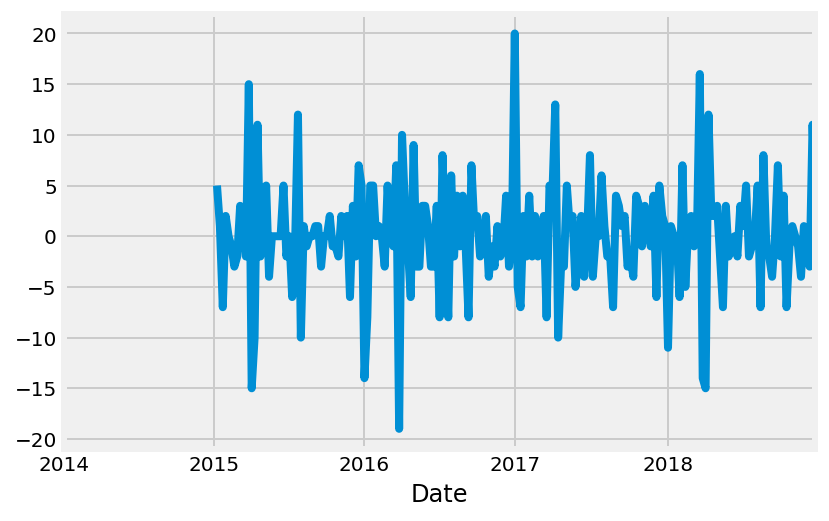

In [89]:
# You can also do seasonal first difference
df['Seasonal First Difference'] = df['Trend First Difference'] - df['Trend First Difference'].shift(52)
df['Seasonal First Difference'].plot()

In [90]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.107643554430495
p-value : 4.0148415465038844e-10
#Lags Used : 10
Number of Observations Used : 197
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# Autocorrelation and Partial Autocorrelation Plots

An autocorrelation plot (also known as a [Correlogram](https://en.wikipedia.org/wiki/Correlogram) ) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

So imagine taking your time series of length T, copying it, and deleting the first observation of copy #1 and the last observation of copy #2. Now you have two series of length T−1 for which you calculate a correlation coefficient. This is the value of of the vertical axis at x=1x=1 in your plots. It represents the correlation of the series lagged by one time unit. You go on and do this for all possible time lags x and this defines the plot.

You will run these plots on your differenced/stationary data. There is a lot of great information for identifying and interpreting ACF and PACF [here](http://people.duke.edu/~rnau/arimrule.htm) and [here](https://people.duke.edu/~rnau/411arim3.htm).

### Autocorrelation Interpretation

The actual interpretation and how it relates to ARIMA models can get a bit complicated, but there are some basic common methods we can use for the ARIMA model. Our main priority here is to try to figure out whether we will use the AR or MA components for the ARIMA model (or both!) as well as how many lags we should use. In general you would use either AR or MA, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), then it suggests to use the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests using MA terms.

_____
### <font color='red'> Important Note! </font> 

Here we will be showing running the ACF and PACF on multiple differenced data sets that have been made stationary in different ways, typically you would just choose a single stationary data set and continue all the way through with that.

The reason we use two here is to show you the two typical types of behaviour you would see when using ACF.
_____

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

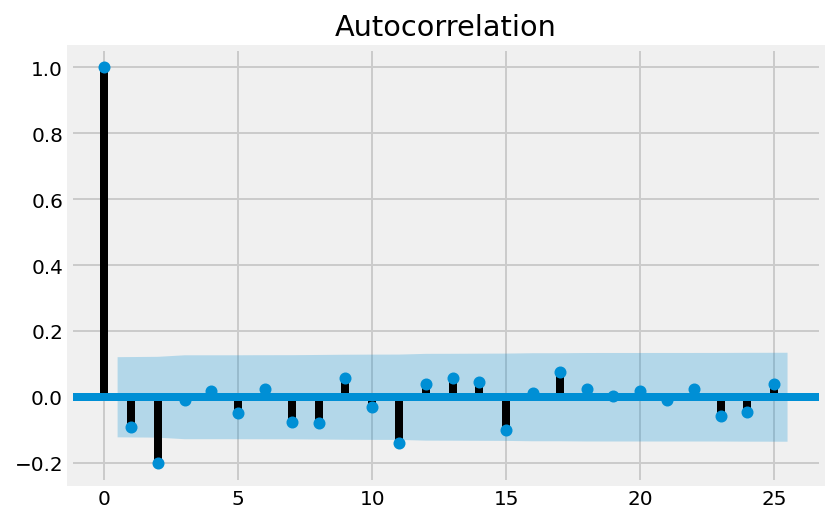

In [92]:
# Duplicate plots
# Check out: https://stackoverflow.com/questions/21788593/statsmodels-duplicate-charts
# https://github.com/statsmodels/statsmodels/issues/1265
fig_first = plot_acf(df["Trend First Difference"].dropna())

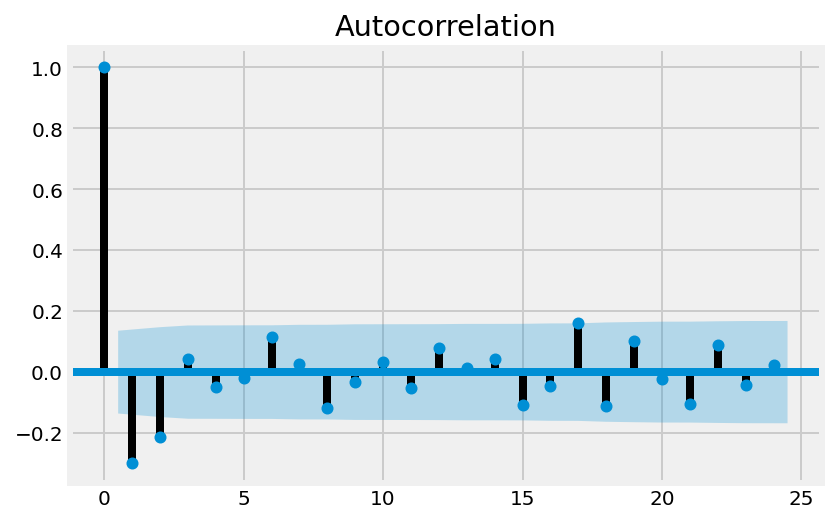

In [93]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

Pandas also has this functionality built in, but only for ACF, not PACF. So I recommend using statsmodels, as ACF and PACF is more core to its functionality than it is to pandas' functionality.

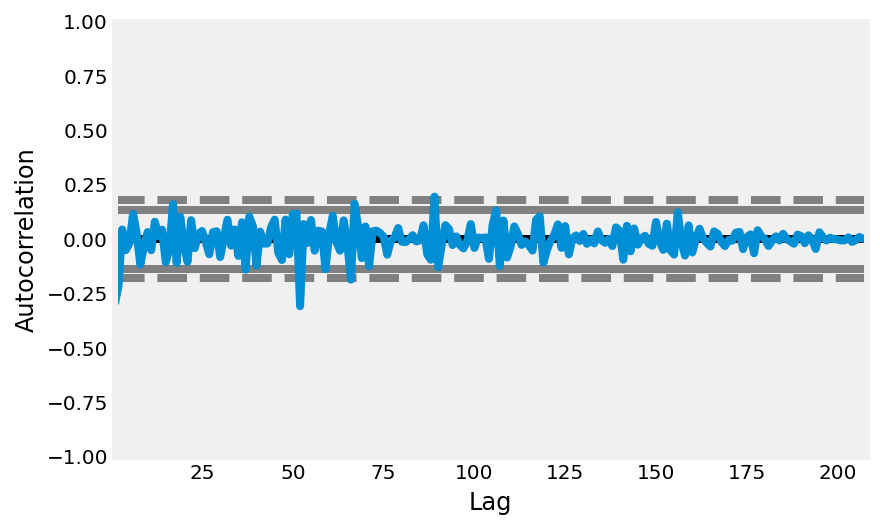

In [94]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Partial Autocorrelation

In general, a partial correlation is a conditional correlation.

It is the correlation between two variables under the assumption that we know and take into account the values of some other set of variables.

For instance, consider a regression context in which y = response variable and x1, x2, and x3 are predictor variables.  The partial correlation between y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

Formally, this is relationship is defined as:

We can then plot this relationship:

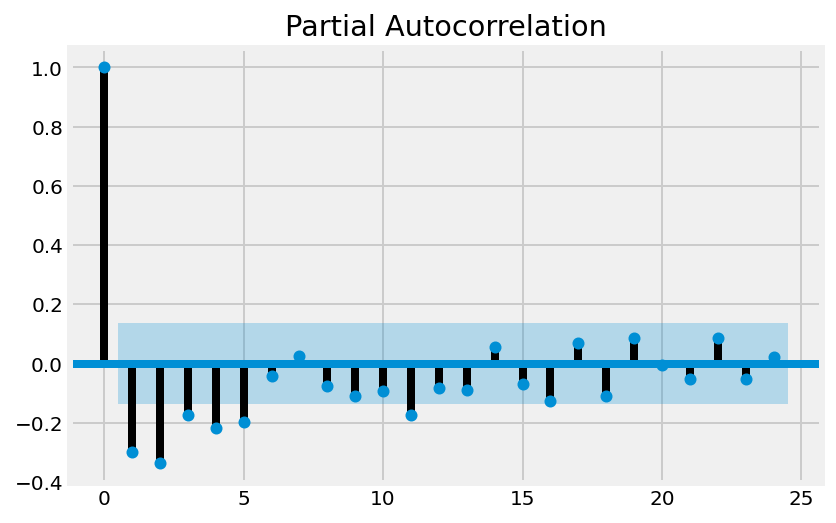

In [95]:
result = plot_pacf(df["Seasonal First Difference"].dropna())

### Interpretation

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

_____
### Final ACF and PACF Plots

We've run quite a few plots, so let's just quickly get our "final" ACF and PACF plots. These are the ones we will be referencing in the rest of the notebook below.
_____

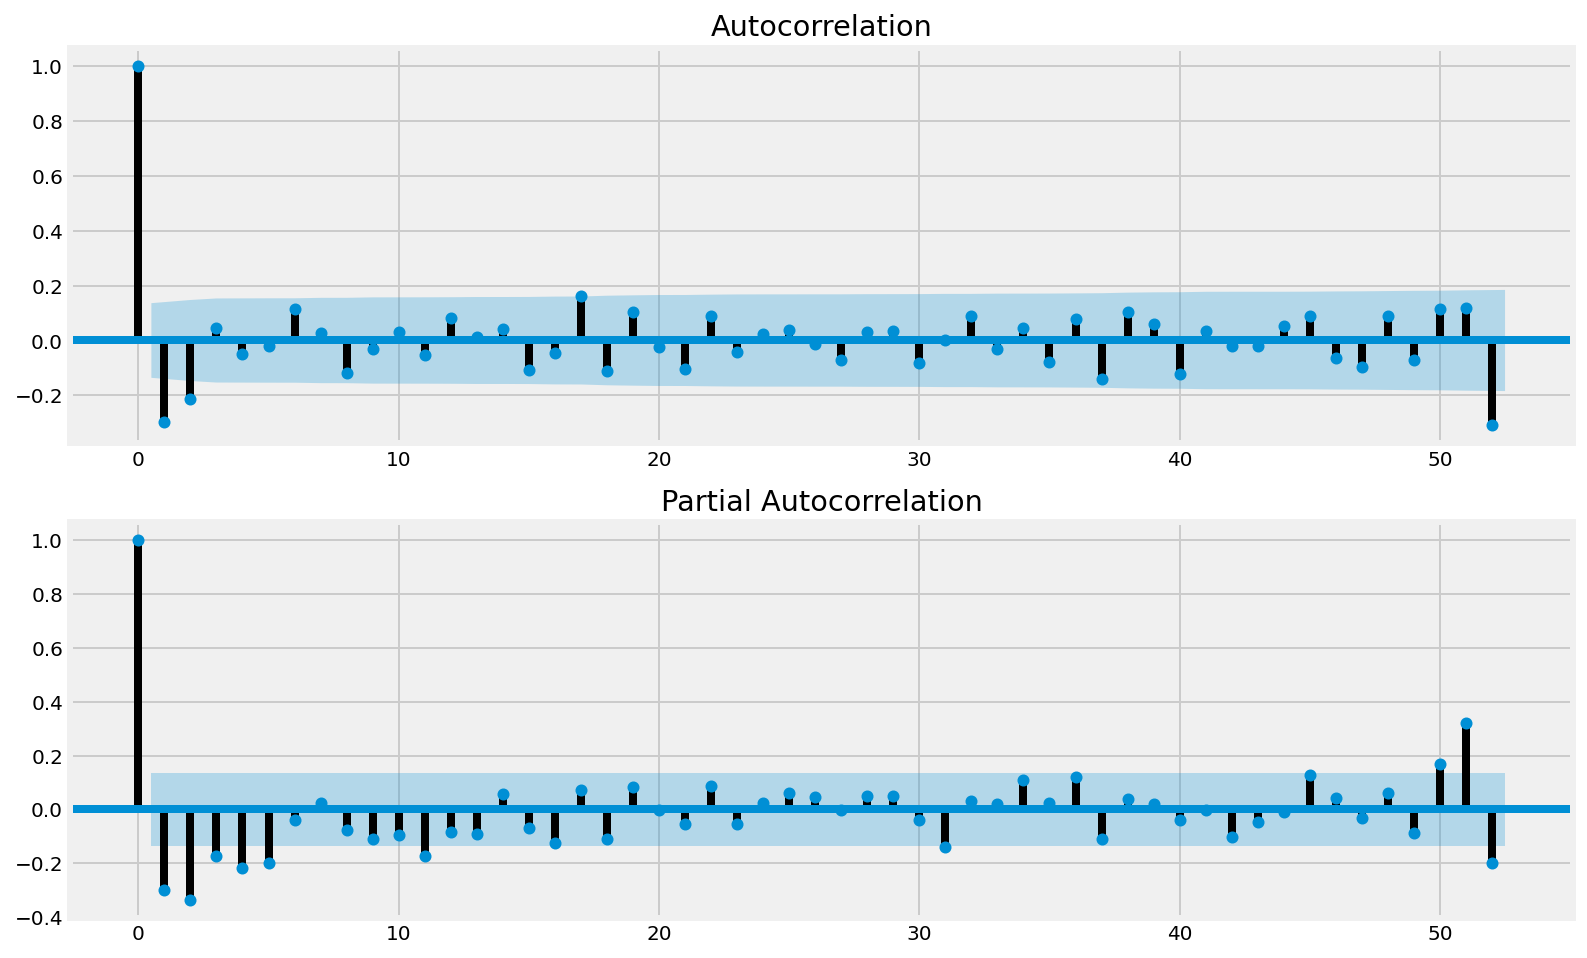

In [96]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[53:], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[53:], lags=52, ax=ax2)

## Using the Seasonal ARIMA model

Finally we can use our ARIMA model now that we have an understanding of our data!

In [97]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

In [99]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(endog, order, exog=None, dates=None, freq=None, missing='none')
 |  
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array_like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array_like, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [100]:
model = sm.tsa.statespace.SARIMAX(df['Trend'],order=(0,1,0), seasonal_order=(1,1,1,52))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                      SARIMAX Results                                       
Dep. Variable:                                Trend   No. Observations:                  261
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 52)   Log Likelihood                -620.871
Date:                              Thu, 23 Apr 2020   AIC                           1247.741
Time:                                      19:21:13   BIC                           1257.754
Sample:                                  01-05-2014   HQIC                          1251.790
                                       - 12-30-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.0871      0.149     -0.586      0.558      -0.379       0.204
ma.S.L52      -0.46

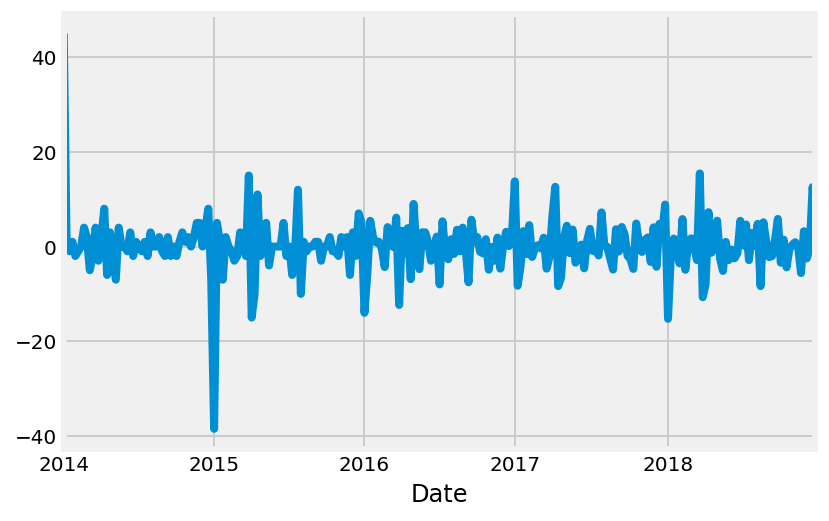

In [101]:
results.resid.plot()

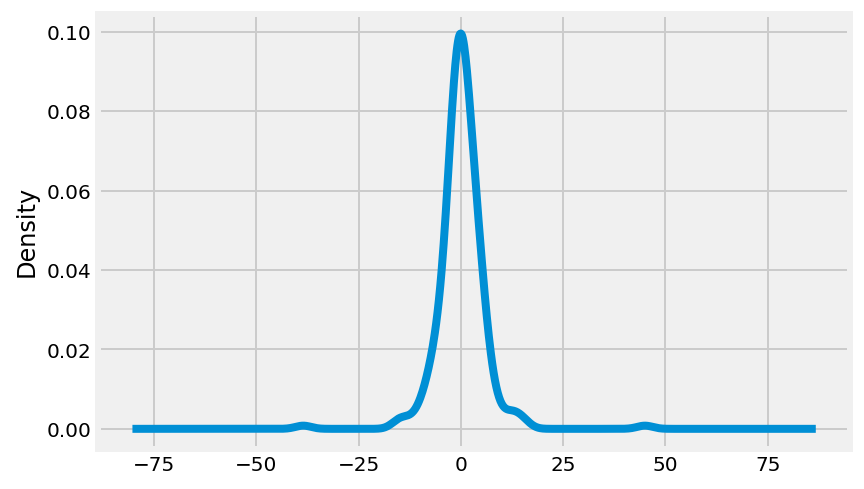

In [102]:
results.resid.plot(kind='kde')

## Prediction of Future Values

Firts we can get an idea of how well our model performs by just predicting for values that we actually already know:

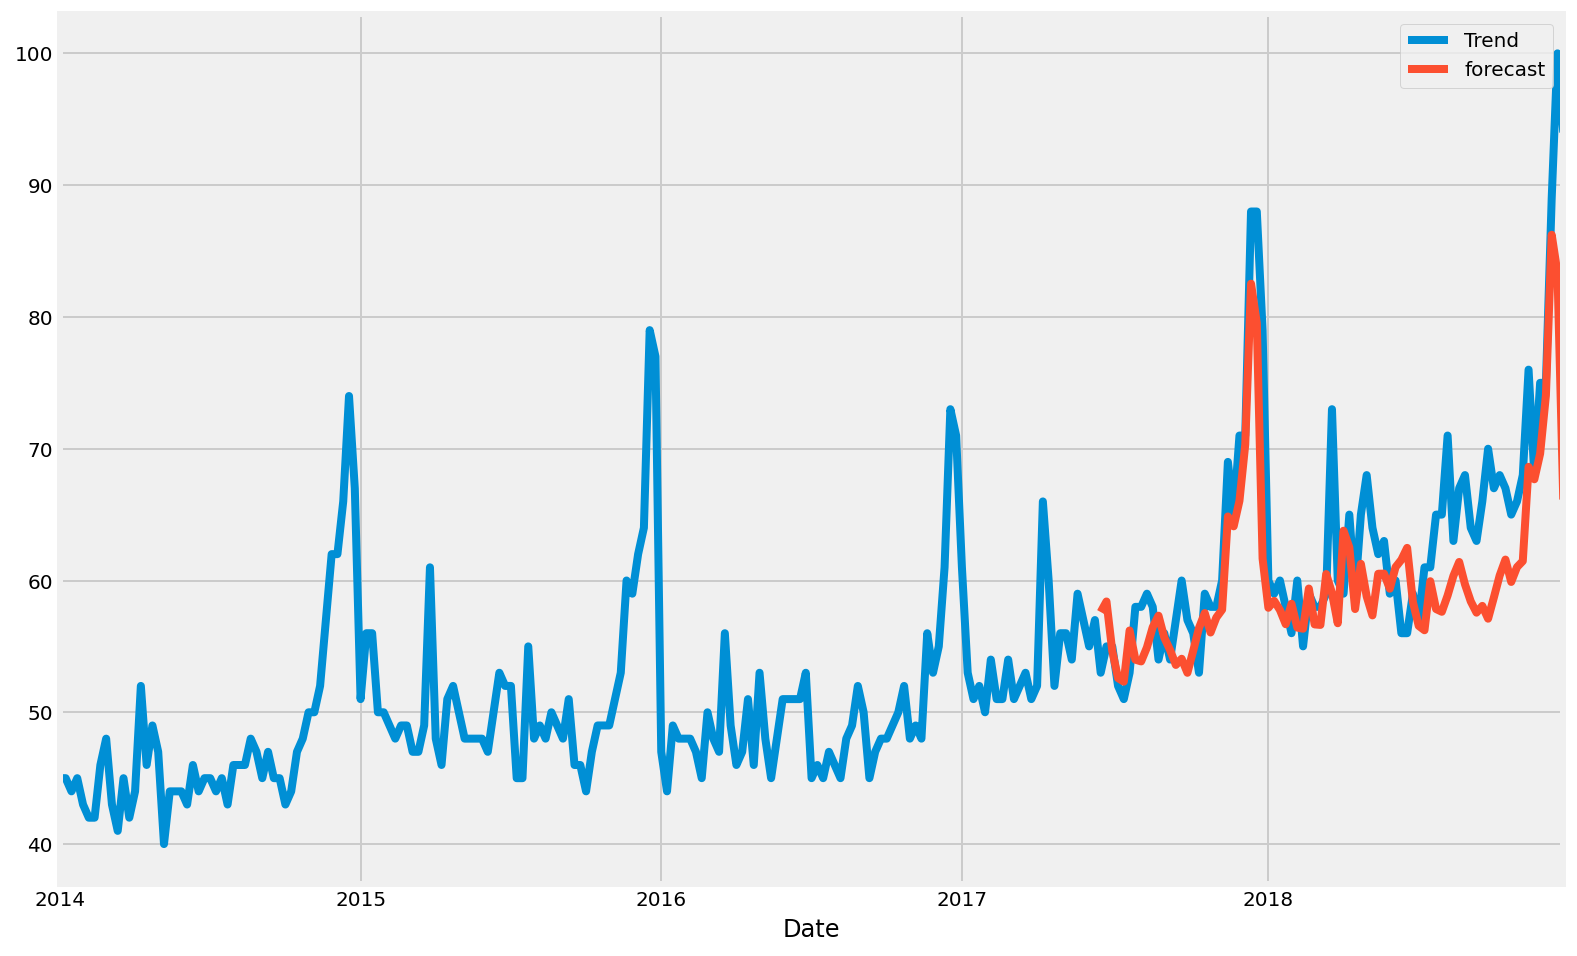

In [103]:
df['forecast'] = results.predict(start = 180, end= 364, dynamic= True)  
df[['Trend','forecast']].plot(figsize=(12,8))

### Forecasting
This requires more time periods, so let's create them with pandas onto our original dataframe!

In [104]:
df.tail()

,Trend,Trend First Difference,Trend Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Date,,,,,,
2018-12-02,75,7.0,15.0,4.0,1.0,69.625538
2018-12-09,75,0.0,-7.0,4.0,0.0,74.043241
2018-12-16,89,14.0,14.0,1.0,-3.0,86.237007
2018-12-23,100,11.0,-3.0,12.0,11.0,83.334349
2018-12-30,94,-6.0,-17.0,15.0,3.0,66.145177


In [105]:
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html
# Alternatives 
# pd.date_range(df.index[-1],periods=12,freq='M')

In [106]:
from pandas.tseries.offsets import DateOffset

In [107]:
future_dates = [df.index[-1] + DateOffset(weeks=x) for x in range(0,52) ]

In [108]:
#future_dates

In [109]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [110]:
future_df = pd.concat([df,future_dates_df])

In [111]:
future_df.head()

,Trend,Trend First Difference,Trend Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2014-01-05,45,NaN,NaN,NaN,NaN,NaN
2014-01-12,45,0.0,NaN,NaN,NaN,NaN
2014-01-19,44,-1.0,-1.0,NaN,NaN,NaN
2014-01-26,45,1.0,2.0,NaN,NaN,NaN
2014-02-02,43,-2.0,-3.0,NaN,NaN,NaN


In [112]:
future_df.tail()

,Trend,Trend First Difference,Trend Second Difference,Seasonal Difference,Seasonal First Difference,forecast
2019-11-24,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-08,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-15,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-22,NaN,NaN,NaN,NaN,NaN,NaN


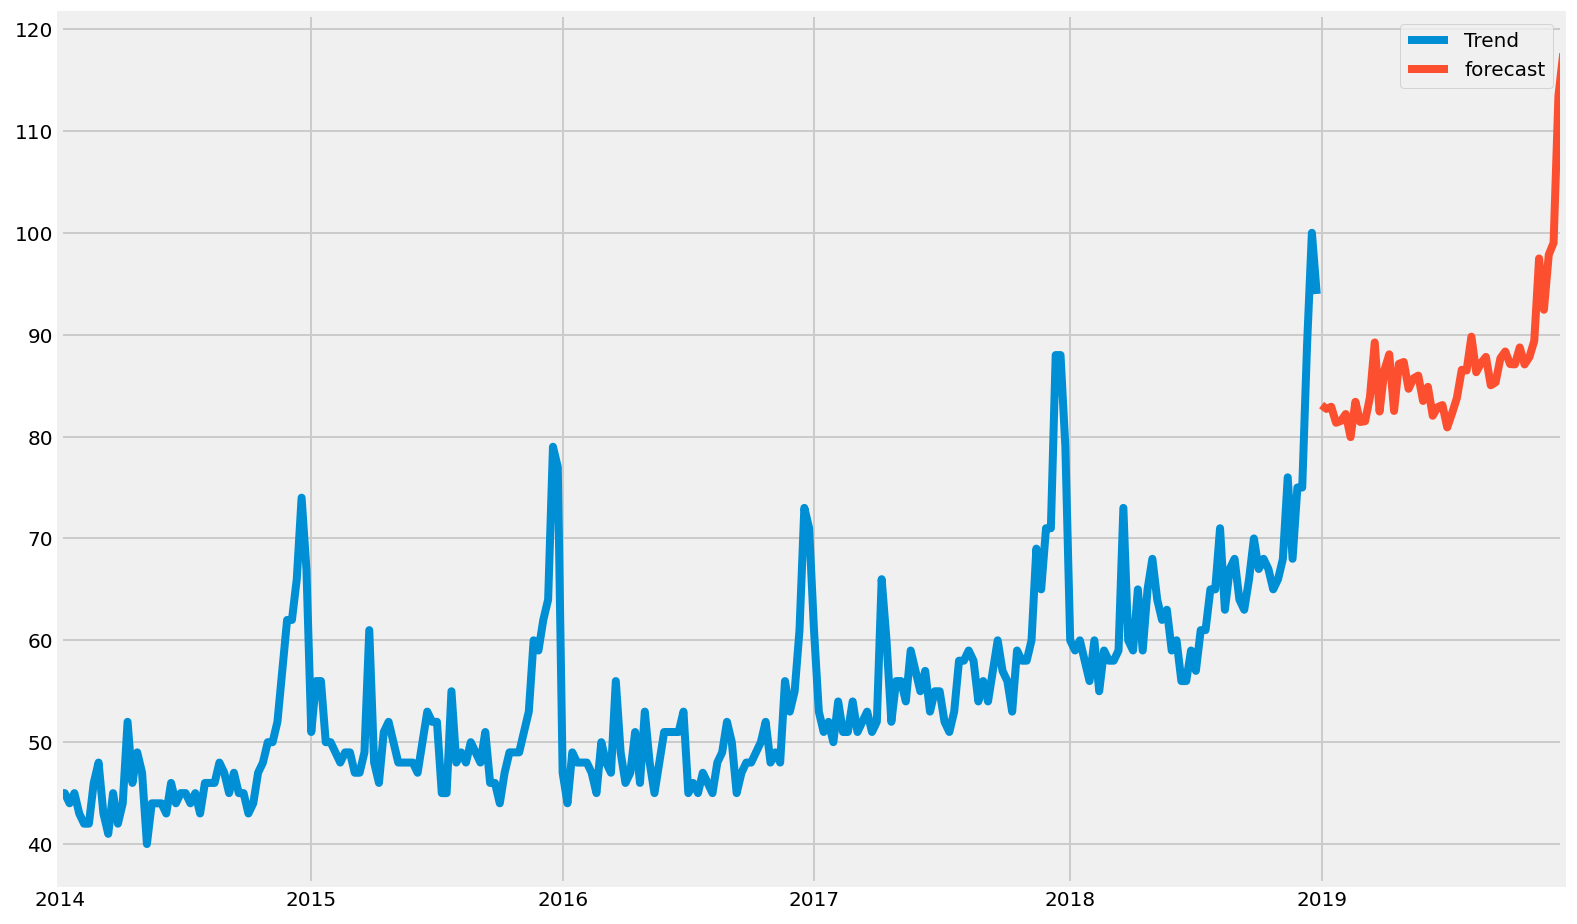

In [113]:
future_df['forecast'] = results.predict(start = 261, end = 312, dynamic= True)  
future_df[['Trend', 'forecast']].plot(figsize=(12, 8))

In [114]:
future_df[['Trend', 'forecast']]

,Trend,forecast
2014-01-05,45,NaN
2014-01-12,45,NaN
2014-01-19,44,NaN
2014-01-26,45,NaN
2014-02-02,43,NaN
...,...,...
2019-11-24,NaN,92.443284
2019-12-01,NaN,97.847550
2019-12-08,NaN,99.014920
2019-12-15,NaN,113.438260
